In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
from scipy.io import loadmat
from scipy.interpolate import griddata
get_dir = os.getcwd()
os.chdir(get_dir)

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
def get_predictions(model, test_data):
    
    u_test, v_test, p_test = model.predict(test_data, batch_size=32)
    
    return u_test, v_test, p_test

def get_repeated_tensors(x, y, lid_vel, num_samples):
    return (np.repeat(x.reshape((1, -1)), num_samples, axis=0),
            np.repeat(y.reshape((1, -1)), num_samples, axis=0),
            np.repeat(np.ones_like(x).reshape((1, -1)) * lid_vel, num_samples, axis=0))

In [3]:
def get_true_test_values(model, param_dir, lid_velocity, base_dir, seq_dir, dm=False):
    
    true_val = []
    pred_val = []
    u_val = {'true': [], 'pred': []}
    v_val = {'true': [], 'pred': []}
    
    param_data = loadmat(param_dir)
    

    x_grid, y_grid = param_data['XP'].T.shape
    xmesh = np.linspace(start=0, stop=1., num=x_grid)
    ymesh = np.linspace(start=0., stop=1., num=y_grid)
    X, Y = np.meshgrid(xmesh, ymesh)
    side_bc = np.zeros((y_grid - 2, 1))
    bbc = np.zeros((1, x_grid))
    xlim = [0., 1.]
    ylim = [0., 1.]

    coord_val = pd.read_csv(seq_dir)
    x_seq, y_seq = coord_val['0'].values, coord_val['1'].values
    
    for i in lid_velocity:
        
        true_data = loadmat(base_dir + 'u_' + str(i) + '.mat')
        tbc = np.ones_like(bbc) * i
        tbc[0, 0] = 0
        tbc[0, -1] = 0

        xbc, ybc, ubc = get_repeated_tensors(x=x_seq, y=y_seq, lid_vel=i, num_samples = len(X.reshape((-1, 1))))

        if dm:
            test_data = [X.reshape((-1, 1)), Y.reshape((-1, 1)), ubc]
        else:
            test_data = [X.reshape((-1, 1)), Y.reshape((-1, 1)), xbc, ybc, ubc]

        u_test, v_test, p_test = get_predictions(model, test_data)
        u_test = u_test.reshape(X.shape)
        v_test = v_test.reshape(X.shape)
        p_test = p_test.reshape(X.shape)

        u_interpolated_data = griddata(
            np.hstack(
                (param_data['XU'].reshape((-1, 1), order='F'), param_data['YU'].reshape((-1, 1), order='F'))),
            true_data['u'][4:], np.hstack((X[1:-1, 1:-1].reshape((-1, 1)), Y[1:-1, 1:-1].reshape((-1, 1)))))
        v_interpolated_data = griddata(
            np.hstack((param_data['XV'].reshape((-1, 1), order='F'), param_data['YV'].reshape((-1, 1), order='F'))),
            true_data['v'][4:], np.hstack((X[1:-1, 1:-1].reshape((-1, 1)), Y[1:-1, 1:-1].reshape((-1, 1)))))
        p_interpolated_data = griddata(
            np.hstack((param_data['XP'].reshape((-1, 1), order='F'), param_data['YP'].reshape((-1, 1), order='F'))),
            true_data['P'][4:], np.hstack((X[1:-1, 1:-1].reshape((-1, 1)), Y[1:-1, 1:-1].reshape((-1, 1)))))
        p_interpolated_data = p_interpolated_data.reshape((x_grid-2, y_grid-2))
        u_padded = np.concatenate((
            bbc, np.concatenate((side_bc, u_interpolated_data.reshape((x_grid - 2, y_grid - 2)), side_bc),
                                axis=1), tbc), axis=0)
        v_padded = np.concatenate(
            (bbc, np.concatenate((side_bc, v_interpolated_data.reshape((x_grid - 2, y_grid - 2)),
                                  side_bc), axis=1), bbc), axis=0)
        
        true_mag = (u_padded ** 2 + v_padded ** 2)**0.5
        pred_mag = (u_test ** 2 + v_test ** 2)**0.5
        
        true_val.append(true_mag)
        pred_val.append(pred_mag)
        
        u_val['true'].append(u_padded)
        u_val['pred'].append(u_test)
        v_val['true'].append(v_padded)
        v_val['pred'].append(v_test)
        
    return X, Y, true_val, pred_val, u_val, v_val

In [4]:
def get_plots(x, y, true_val, pred_val, u_val, v_val, grid_spec, plot_title, plot_save, 
              plot_dir, fig_size,shrink=1, dm=False, lxd = [0.5, 0.5],lyd=[0.1, 0.9], 
              lx=0.25, rx=0.75, text_y=0.9, clim=[0., 2.5], eclim=[0., 0.08], 
              lbs=['PINTO Prediction \n Z', 'Numerical Solution \n Z', 'Relative Error \n Z'], 
              dt=['Seen', 'Unseen'], cbar_kwargs=None):
    
    xlim = [x.min(), x.max()]
    ylim = [y.min(), y.max()]
    
    fig, ax = plt.subplots(3, len(true_val), figsize=fig_size, sharex='col', sharey='row', 
                           gridspec_kw =grid_spec)
    # ax = ax.ravel()

    # Create two GridSpec objects for left and right sections
    gs = mpl.gridspec.GridSpec(4, 4, figure=fig)
    level = np.linspace(clim[0], clim[1], num=10)
    err_level = np.linspace(eclim[0], eclim[1], num=7)
   
    for j in range(len(true_val)):
    
        pres = ax[0][j].streamplot(x, y-1, u_val['pred'][j], v_val['pred'][j], color='k', 
                                    linewidth=0.5)
        pre = ax[0][j].contourf(x, y-1, pred_val[j], level, cmap='rainbow')

        trus = ax[1][j].streamplot(x, y-1, u_val['true'][j], v_val['true'][j], color='k', 
                                    linewidth=0.5)
        ref = ax[1][j].contourf(x, y-1, true_val[j], level, cmap='rainbow')

        rel_err = abs(true_val[j] - pred_val[j])/(1 + abs(true_val[j]))

        if dm:
            err = ax[2][j].contourf(x, y-1, rel_err, err_level, cmap='Blues', extend='both')
            err.cmap.set_under('orange')
            err.cmap.set_over('orange')
        else:
            err = ax[2][j].contourf(x, y-1, rel_err, err_level, cmap='Blues')
        

        ax[0][j].set_title(plot_title[0][j],fontsize=10, fontweight='bold')
        ax[0][j].set_xlim(xlim[0], xlim[1])
        ax[0][j].set_ylim(ylim[0]-1, ylim[1]-1)
                
        ax[1][j].set_xlim(xlim[0], xlim[1])
        ax[1][j].set_ylim(ylim[0]-1, ylim[1]-1)
        
        ax[2][j].set_xlabel('X', fontsize=10, fontweight='bold')

        for row in ax:
            row[j].set_aspect('equal', adjustable='box')

    
    # plt.subplots_adjust(wspace=0.4, right=0.9)
    pcbar = fig.colorbar(pre, ax=ax[0, :], **cbar_kwargs)
    pcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    pcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    
    tcbar = fig.colorbar(ref, ax=ax[1, :], **cbar_kwargs)
    tcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    tcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    ecbar = fig.colorbar(err, ax=ax[2, :], **cbar_kwargs)
    ecbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    
    ax[0][0].set_ylabel(lbs[0], fontsize=10, fontweight='bold')
    ax[1][0].set_ylabel(lbs[1], fontsize=10, fontweight='bold')
    ax[2][0].set_ylabel(lbs[2], fontsize=10, fontweight='bold')
    
    fig.text(lx, text_y, dt[0], ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(rx, text_y, dt[1], ha='center', va='center', fontsize=12, fontweight='bold')

    # Add vertical line using figure coordinates
    line = plt.Line2D(lxd, lyd, transform=fig.transFigure, color='black', linewidth=2)
    fig.add_artist(line)
        
    if plot_save:
        plt.savefig(plot_dir + '.png', dpi=300, bbox_inches = 'tight', format='png')

## Figure_11: Lid Driven Flow Plots

In [5]:
PINTO_model = keras.models.load_model('../Trained_models/LDF_PINTO/LDF_PINTO_model.keras')

lid_velocities = [1, 2, 1.5, 2.5]
seq_dir = '../Trained_models/LDF_PINTO/seq.csv'
param_dir = '../CFD_data/param.mat'
base_dir = '../CFD_data/'

x, y, train_val_true, train_val_pred, tr_u_val, tr_v_val = get_true_test_values(
    model=PINTO_model, param_dir=param_dir, base_dir=base_dir,
    lid_velocity=lid_velocities, seq_dir=seq_dir)

128/128 [==============================] - 0s 2ms/step


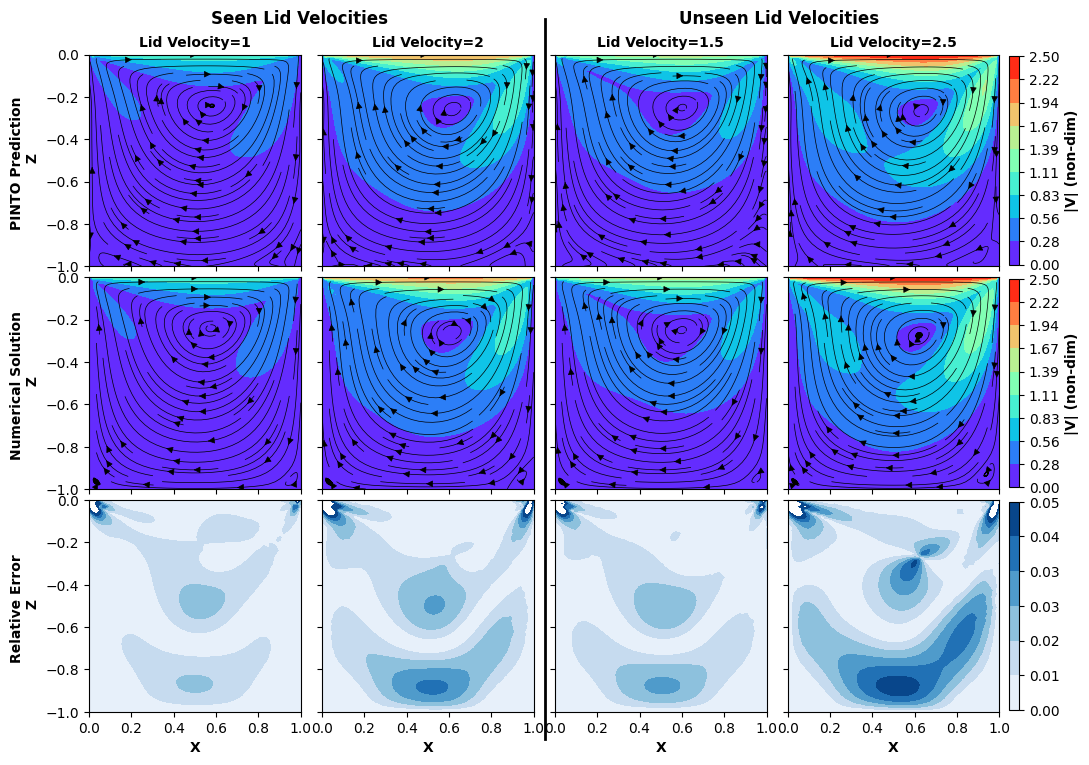

In [6]:
pdir = 'Figure_11.png'
pt = [['Lid Velocity=1', 'Lid Velocity=2', 'Lid Velocity=1.5', 'Lid Velocity=2.5']] # plot title for each columns
plt_save = True  # argument to save plot 
clim = [0., 2.5] # contour plots colorbar limits
eclim = [0., 0.05] # relative colorbar limits   
cbar_kwargs = {
        'fraction': 0.0112, 
        'pad': 0.01,
        'format': tick.FormatStrFormatter('%.2f')
    }

grid_spec = {'wspace': 0.1, 'hspace': -0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
get_plots(x,  y, true_val=train_val_true, pred_val=train_val_pred, u_val=tr_u_val, v_val=tr_v_val, 
          plot_save=plt_save, grid_spec=grid_spec, plot_title=pt, plot_dir=pdir, fig_size=(12,9), shrink=1,
          lxd=[0.505, 0.505], lyd=[0.1, 0.9], lx=0.3, rx=0.7, text_y=0.9, clim=clim, eclim=eclim,
          lbs=['PINTO Prediction \n Z', 'Numerical Solution \n Z', 'Relative Error \n Z'], dt=['Seen Lid Velocities', 'Unseen Lid Velocities'], cbar_kwargs=cbar_kwargs)

## PI-DeepONets Plots

In [7]:
pid_model = keras.models.load_model('../Trained_models/LDF_DeepONet/LDF_Deeponet_model.keras')

seq_dir = '../Trained_models/LDF_DeepONet/seq.csv'
x, y, pid_val_true, pid_val_pred, pid_u_val, pid_v_val = get_true_test_values(model=pid_model, param_dir=param_dir, base_dir=base_dir,
                                                                              lid_velocity=lid_velocities, seq_dir=seq_dir, dm=True)

128/128 [==============================] - 0s 2ms/step


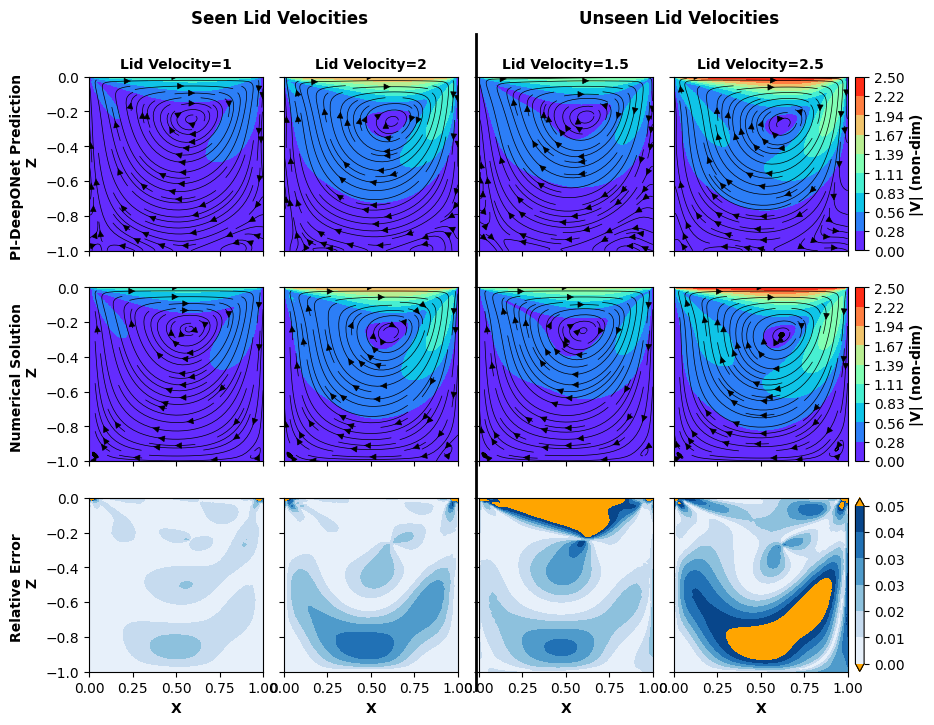

In [8]:
pdir = 'Pid_Lid_Driven_training_testing_plots'
pt = [['Lid Velocity=1', 'Lid Velocity=2', 'Lid Velocity=1.5', 'Lid Velocity=2.5']] # plot title for each columns
plt_save = False  # argument to save plot 
clim = [0., 2.5] # contour plots colorbar limits
eclim = [0., 0.05] # relative colorbar limits 

grid_spec = {'wspace': 0.12, 'hspace': 0.08, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
get_plots(x,  y, true_val=pid_val_true, pred_val=pid_val_pred, u_val=pid_u_val, v_val=pid_v_val, 
          plot_save=plt_save, dm=True, grid_spec=grid_spec, plot_title=pt, plot_dir=pdir, fig_size=(10,8), shrink=1,
          lxd=[0.512, 0.512], lyd=[0.1, 0.92], lx=0.315, rx=0.715, text_y=0.94, clim=clim, eclim=eclim,
          lbs=['PI-DeepONet Prediction \n Z', 'Numerical Solution \n Z', 'Relative Error \n Z'], dt=['Seen Lid Velocities', 'Unseen Lid Velocities'],  cbar_kwargs=cbar_kwargs)

## Table1: Performance Metrics

In [9]:
def get_metrics(true_val, pred_val):
    rel_err = abs(np.concatenate(true_val, axis=0) - np.concatenate(pred_val, axis=0))/(1 + abs(np.concatenate(true_val)))
    mean_metric = np.mean(rel_err)
    std_metric = np.std(rel_err)
    
    return mean_metric, std_metric

In [10]:
training_velocities = [1, 2, 3]
testing_velocities = [2.2, 2.3, 2.4, 2.6, 2.7, 2.8, 2.9, 3.1, 3.2, 3.3, 3.4, 3.6, 3.7, 3.8, 3.9, 4]
seq_dir = '../Trained_models/LDF_PINTO/seq.csv'
train_param_dir = '../CFD_data/param.mat'
test_param_dir = '../CFD_data/param.mat'
train_base_dir = '../CFD_data/'
test_base_dir = '../CFD_data/'

_, _, tno_train_true, tno_train_pred, tno_tr_u_val, tno_tr_v_val = get_true_test_values(
    model=PINTO_model, param_dir=train_param_dir, base_dir=train_base_dir,
    lid_velocity=training_velocities, seq_dir=seq_dir)

_, _, tno_test_true, tno_test_pred, tno_ts_u_val, tno_ts_v_val = get_true_test_values(
    model=PINTO_model, param_dir=test_param_dir, base_dir=test_base_dir,
    lid_velocity=testing_velocities, seq_dir=seq_dir)

 99/128 [======================>.......] - ETA: 0s

128/128 [==============================] - 0s 2ms/step


In [11]:
seq_dir = '../Trained_models/LDF_DeepONet/seq.csv'

_, _, pid_train_true, pid_train_pred, pid_tr_u_val, pid_tr_v_val = get_true_test_values(
    model=pid_model, param_dir=train_param_dir, base_dir=train_base_dir,
    lid_velocity=training_velocities, seq_dir=seq_dir, dm=True)

_, _, pid_test_true, pid_test_pred, pid_ts_u_val, pid_ts_v_val = get_true_test_values(
    model=pid_model, param_dir=test_param_dir, base_dir=test_base_dir,
    lid_velocity=testing_velocities, seq_dir=seq_dir, dm=True)

128/128 [==============================] - 0s 2ms/step


In [12]:
print("PINTO metrics \n")

train_mean_metric, train_std_metric = get_metrics(tno_train_true, tno_train_pred)
test_mean_metric, test_std_metric = get_metrics(tno_test_true, tno_test_pred)

print("mean relative error across all training sets is: ",train_mean_metric)
print("std of relative error across training sets is: ",train_std_metric)
print("mean relative error across all testing sets is: ",test_mean_metric)
print("std of relative error across testing sets is: ",test_std_metric)

PINTO metrics 

mean relative error across all training sets is:  0.01356039123909194
std of relative error across training sets is:  0.014403755315292787
mean relative error across all testing sets is:  0.02782062589250442
std of relative error across testing sets is:  0.024906968465739237


In [13]:
print("PI-DeepONets metrics \n")

train_mean_metric, train_std_metric = get_metrics(pid_train_true, pid_train_pred)
test_mean_metric, test_std_metric = get_metrics(pid_test_true, pid_test_pred)

print("mean relative error across all training sets is: ",train_mean_metric)
print("std of relative error across training sets is: ",train_std_metric)
print("mean relative error across all testing sets is: ",test_mean_metric)
print("std of relative error across testing sets is: ",test_std_metric)

PI-DeepONets metrics 

mean relative error across all training sets is:  0.019587678604638333
std of relative error across training sets is:  0.02310985574482369
mean relative error across all testing sets is:  0.06084006047993
std of relative error across testing sets is:  0.06611267975642025


## Figure_12: Lid Driven Cavity flow comparisons

In [14]:
def get_plots_comp(x, y, true_val, tno_pred_val, tno_u_val, tno_v_val,
                   pid_pred_val, pid_u_val, pid_v_val,  
                   grid_spec, plot_title, plot_save, plot_dir, fig_size, shrink=1, 
           	   dm=False, lxd = [0.5, 0.5],lyd=[0.1, 0.9], lx=0.25, rx=0.75, text_y=0.9, clim=[0., 2.5], eclim=[0., 0.08], 
           	   lbs=['Z', 'Relative Error \n Z'], dt=['PINTO Prediction', 'PI-DeepONet Prediction'], over_color='grey', 
               cbar_kwargs=None):
    
    xlim = [x.min(), x.max()]
    ylim = [y.min(), y.max()]
    
    fig, ax = plt.subplots(3, len(true_val) + len(true_val), figsize=fig_size, sharex='col', sharey='row', 
                           gridspec_kw =grid_spec)

    # Create two GridSpec objects for left and right sections
    gs = mpl.gridspec.GridSpec(4, 4, figure=fig)
    level = np.linspace(clim[0], clim[1], num=10)
    err_level = np.concatenate([np.linspace(eclim[0], eclim[1], num=7)])

    for j in range(len(true_val)):
    
        ax[0][2*j].streamplot(x, y-1, tno_u_val['pred'][j], tno_v_val['pred'][j], color='k', linewidth=0.5)
        pre = ax[0][2*j].contourf(x, y-1, tno_pred_val[j], level, cmap='rainbow')

        ax[1][2*j].streamplot(x, y-1, tno_u_val['true'][j], tno_v_val['true'][j], color='k', linewidth=0.5)
        ns = ax[1][2*j].contourf(x, y-1, true_val[j], level, cmap='rainbow')
        ax[1][2*j+1].streamplot(x, y-1, tno_u_val['true'][j], tno_v_val['true'][j], color='k', linewidth=0.5)
        ns = ax[1][2*j+1].contourf(x, y-1, true_val[j], level, cmap='rainbow')
        

        trus = ax[0][2*j+1].streamplot(x, y-1, pid_u_val['true'][j], pid_v_val['true'][j], color='k', 
                                    linewidth=0.5)
        ref = ax[0][2*j+1].contourf(x, y-1, pid_pred_val[j], level, cmap='rainbow')

        tno_rel_err = abs(true_val[j] - tno_pred_val[j])/(1 + abs(true_val[j]))
        pid_rel_err = abs(true_val[j] - pid_pred_val[j])/(1 + abs(true_val[j]))

        pid_err = ax[2][2*j+1].contourf(x, y-1, pid_rel_err, err_level, cmap='Blues', extend='max')
        # pid_err.cmap.set_under('orange')
        pid_err.cmap.set_over(over_color)
        tno_err = ax[2][2*j].contourf(x, y-1, tno_rel_err, err_level, cmap='Blues')
        
        
        ax[0][j].set_title(plot_title[0][j],fontsize=10, fontweight='bold')
        ax[0][j+2].set_title(plot_title[0][j],fontsize=10, fontweight='bold')
        
        ax[0][j].set_xlim(xlim[0], xlim[1])
        ax[0][j].set_ylim(ylim[0]-1, ylim[1]-1)
        ax[0][j+2].set_xlim(xlim[0], xlim[1])
        ax[0][j+2].set_ylim(ylim[0]-1, ylim[1]-1)

        ax[1][j].set_xlim(xlim[0], xlim[1])
        ax[1][j].set_ylim(ylim[0]-1, ylim[1]-1)
        ax[1][j+2].set_xlim(xlim[0], xlim[1])
        ax[1][j+2].set_ylim(ylim[0]-1, ylim[1]-1)
        
        
        ax[2][j].set_xlabel('X', fontsize=10, fontweight='bold')
        ax[2][j+2].set_xlabel('X', fontsize=10, fontweight='bold')

        for row in ax:
            row[j].set_aspect('equal', adjustable='box')
            row[j+2].set_aspect('equal', adjustable='box')
            


    
    pcbar = fig.colorbar(pre, ax=ax[0, :], **cbar_kwargs)
    pcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    pcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    
    tcbar = fig.colorbar(ns, ax=ax[1, :], **cbar_kwargs)
    tcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    tcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    ecbar = fig.colorbar(pid_err, ax=ax[2, :], extend='max', extendfrac=0.05, extendrect=True, **cbar_kwargs)
    ecbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    
    ax[0][0].set_ylabel(lbs[0], fontsize=10, fontweight='bold')
    ax[1][0].set_ylabel(lbs[1], fontsize=10, fontweight='bold')
    ax[2][0].set_ylabel(lbs[2], fontsize=10, fontweight='bold')
#     ax[2][0].set_ylabel(lbs[2], fontsize=10, fontweight='bold')
    
    fig.text(lx, text_y, dt[0], ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(rx, text_y, dt[1], ha='center', va='center', fontsize=12, fontweight='bold')

    # Add vertical line using figure coordinates
    line = plt.Line2D(lxd, lyd, transform=fig.transFigure, color='black', linewidth=2)
    fig.add_artist(line)
        
    if plot_save:
        plt.savefig(plot_dir + '.png', dpi=300, bbox_inches = 'tight', format='png')

In [15]:
lid_velocities = [1.2, 3.5]
seq_dir = '../Trained_models/LDF_PINTO/seq.csv'
param_dir = '../CFD_data/param.mat'
base_dir = '../CFD_data/'

x, y, true, tno_pred, tno_u_val, tno_v_val = get_true_test_values(
    model=PINTO_model, param_dir=param_dir, base_dir=base_dir,
    lid_velocity=lid_velocities, seq_dir=seq_dir)

x, y, true, pid_pred, pid_u_val, pid_v_val = get_true_test_values(
    model=pid_model, param_dir=param_dir, base_dir=base_dir,
    lid_velocity=lid_velocities, seq_dir=seq_dir, dm=True)

128/128 [==============================] - 0s 2ms/step


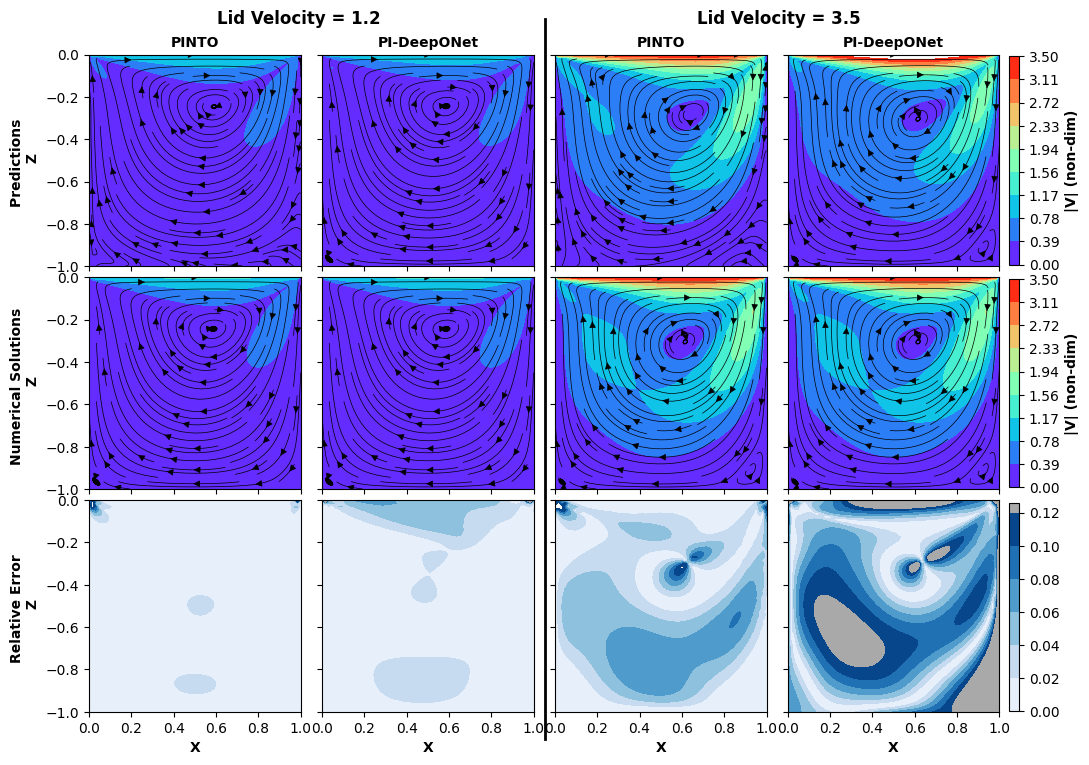

In [16]:
pdir = 'Figure_10'
pt = [['PINTO', 'PI-DeepONet']] # plot columns title 
plt_save = False
clim = [0., 3.5] # contour plot colorbar limits
eclim = [0., 0.12] # error plot colorbar limits

grid_spec = {'wspace': 0.1, 'hspace': -0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
cbar_kwargs = {
        'fraction': 0.0112, 
        'pad': 0.01,
        'format': tick.FormatStrFormatter('%.2f')
    }
get_plots_comp(x, y, true, tno_pred, tno_u_val, tno_v_val,
                   pid_pred, pid_u_val, pid_v_val,  
                   grid_spec, plot_title=pt, plot_save=plt_save, plot_dir=pdir, fig_size=(12, 9), shrink=1, 
           	   dm=True, lxd = [0.505, 0.505],lyd=[0.1, 0.9], lx=0.3, rx=0.7, text_y=0.9, clim=clim, eclim=eclim, 
           	   lbs=['Predictions \n Z', 'Numerical Solutions \n Z', 'Relative Error \n Z'], 
		   dt=[f'Lid Velocity = {lid_velocities[0]}', f'Lid Velocity = {lid_velocities[1]}'], over_color='darkgray', cbar_kwargs=cbar_kwargs)

## Appendix A: Performance metrics

In [17]:
def get_metrics_tableA3(train_true_val, test_true_val,  train_pred_val, test_pred_val, index):
    
    RMSE = np.sqrt(np.mean((np.concatenate(train_true_val, axis=0) - np.concatenate(train_pred_val, axis=0))**2))
    MAE = np.mean(abs((np.concatenate(train_true_val, axis=0) - np.concatenate(train_pred_val, axis=0))))
    tsRMSE = np.sqrt(np.mean((np.concatenate(test_true_val, axis=0) - np.concatenate(test_pred_val, axis=0))**2))
    tsMAE = np.mean(abs((np.concatenate(test_true_val, axis=0) - np.concatenate(test_pred_val, axis=0))))

    return pd.DataFrame({'train_RMSE': [RMSE], 'train_MAE':[MAE], 'test_RMSE': [tsRMSE], 'test_MAE': [tsMAE]}, index=index)

In [18]:
pinto_df = get_metrics_tableA3(train_true_val=tno_train_true, test_true_val=tno_test_true, train_pred_val=tno_train_pred, test_pred_val=tno_test_pred, index=['PINTO'])
pid_df = get_metrics_tableA3(train_true_val=pid_train_true, test_true_val=pid_test_true, train_pred_val=pid_train_pred, test_pred_val=pid_test_pred, index=['PI-DeepONets'])
cdf = pd.concat((pinto_df, pid_df), axis=0)
cdf

,train_RMSE,train_MAE,test_RMSE,test_MAE
PINTO,0.030719,0.019278,0.064247,0.045117
PI-DeepONets,0.051356,0.028795,0.198323,0.105539


In [19]:
def get_metrics_tableA4(train_true_val, test_true_val,  train_pred_val, test_pred_val, index):
    
    RMSE = np.sqrt(np.mean((np.concatenate(train_true_val, axis=0) - np.concatenate(train_pred_val, axis=0))**2))
    MAE = np.mean(abs((np.concatenate(train_true_val, axis=0) - np.concatenate(train_pred_val, axis=0))))
    tsRMSE = np.sqrt(np.mean((np.concatenate(test_true_val, axis=0) - np.concatenate(test_pred_val, axis=0))**2))
    tsMAE = np.mean(abs((np.concatenate(test_true_val, axis=0) - np.concatenate(test_pred_val, axis=0))))
    
    tnRMSE = RMSE/np.sqrt(np.mean(np.concatenate(train_true_val, axis=0)**2))
    tRMAE = MAE/np.mean(abs(np.concatenate(train_true_val, axis=0)))
    tsnRMSE = tsRMSE/np.sqrt(np.mean(np.concatenate(test_true_val, axis=0)))
    tsRMAE = tsMAE/np.mean(abs(np.concatenate(test_true_val, axis=0)))

    return pd.DataFrame({'train_nRMSE': [tnRMSE], 'train_RMAE':[tRMAE], 'test_nRMSE': [tsnRMSE], 'test_RMAE': [tsRMAE]}, index=index)

In [20]:
pinto_df = get_metrics_tableA4(train_true_val=tno_train_true, test_true_val=tno_test_true, train_pred_val=tno_train_pred, test_pred_val=tno_test_pred, index=['PINTO'])
pid_df = get_metrics_tableA4(train_true_val=pid_train_true, test_true_val=pid_test_true, train_pred_val=pid_train_pred, test_pred_val=pid_test_pred, index=['PI-DeepONets'])
cdf = pd.concat((pinto_df, pid_df), axis=0)
cdf

,train_nRMSE,train_RMAE,test_nRMSE,test_RMAE
PINTO,0.052292,0.049478,0.081736,0.073024
PI-DeepONets,0.087421,0.073904,0.252310,0.170820


## Appendix C: Computational Time 

In [28]:
xdisc = np.linspace(0, 1, 256)
ydisc = np.linspace(0, 1, 256)
X, Y = np.meshgrid(xdisc, ydisc)
xin = X.reshape((-1, 1))
yin  = Y.reshape((-1, 1))
x_sen = np.random.rand(len(xin), 40)
y_sen = np.random.rand(len(xin), 40)
u_sen = np.random.rand(len(xin), 40)

_ = PINTO_model.predict([xin, yin, x_sen, y_sen, u_sen], batch_size=256*256, verbose=0)
for i in range(10):
    _ = PINTO_model.predict([xin, yin, x_sen, y_sen, u_sen], batch_size=256*256)

1/1 [==============================] - 0s 97ms/step
